## Reversionspendel

In [135]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

numpy.set_printoptions(linewidth=100)

Populating the interactive namespace from numpy and matplotlib


/home/ca/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
A = loadtxt('./versuch1.csv', delimiter=',', skiprows=1,
           converters=dict(zip([2, 4], [lambda s: NaN if s==b'' else float(s)]*2)))
n, T1, dev_T1, T2, dev_T2 = transpose(A)

In [18]:
dev_T1
dev_T2

array([   nan, 0.0024,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan])

array([0.007 , 0.0106,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan])

In [19]:
mult = [[2.241, 2.250, 2.258, 2.258], [1.908, 1.923], [1.805, 1.806, 1.801, 1.804]]
var = 0
for l in mult:
    l = array(l)
    m = mean(l)
    q = (l - m)/m
    print(q)
    var += sum(q**2)
devq = sqrt(var)
devq, devq * 1.8

[-0.00477406 -0.00077717  0.00277562  0.00277562]
[-0.00391543  0.00391543]
[ 0.00055432  0.00110865 -0.00166297  0.        ]


(0.008588759713942287, 0.015459767485096117)

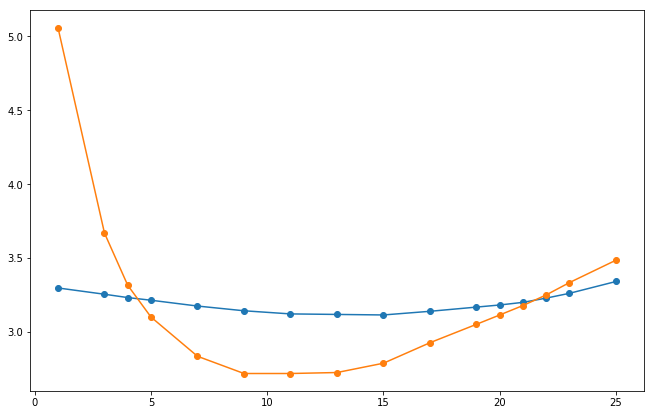

In [20]:
plt.plot(n, transpose([T1**2, T2**2]), 'o-')

In [203]:
def fun1(x, a, b, x0):
    return a/(x - x0) + b*(x - x0)

def fun2(x, a, b, c):
    return (a + b * x**2) / (x - c)

def fun3(x, a, b, c, x0):
    return (a + b * (x - x0)**2) / (x - x0 - c)

def jac3(x, a, b, c, x0):
    return transpose([1/(-c + x - x0),
                  -((x - x0)**2/(c - x + x0)),
                  (a + b*(x - x0)**2)/(c - x + x0)**2,
                  -b + (a + b*c**2)/(c - x + x0)**2])

def dx(x, a, b, c, x0):
    return b - (a + b*c**2)/(x - x0 - c)**2

In [22]:
# wird jetzt doch nicht mehr gebraucht, nachdem ich sinnvolle Startwerde für p1 gefunden habe...
# aber ich lass das mal drin weil die Methode mal anders vielleicht praktisch sein könnte
def fit_curve(f, x, y, p0=None, maxfev=3000, fixed=None, jac=None, **kwargs):
    nargs = f.__code__.co_argcount - 1
    if fixed == None:
        fixed = [None]*nargs
    if p0 == None:
        p0 = [1]*nargs
    assert len(fixed) == len(p0) == nargs, (nargs, fixed, p0)
    p0it = iter(p0)
    p0_ = array([p0[i] for i in range(nargs) if fixed[i] is None])
    
    ff = lambda *args: f(*(arg for i, arg in enumerate(args) if i==0 or not fixed[i-1]))
    def ff(*args):
        it = iter(args)
        return f(next(it), *(next(it) if val is None else val for val in fixed))
    
    def jac_(*args):
        it = iter(args)
        grad = jac(next(it), *(next(it) if val is None else val for val in fixed))
        return array([[rad[i] for i in range(nargs) if fixed[i] is None]])
    
    popt, pcov = scipy.optimize.curve_fit(ff, x, y, p0=p0_, maxfev=maxfev, **kwargs)
    pit = iter(popt)
    return array([next(pit) if val is None else val for val in fixed]), pcov

(array([-1.60466904e+02, -8.52661719e-02,  4.23231508e+01,  3.19450684e+01]),
 array([3.34572839e+01, 1.33293908e-02, 1.21606431e+01, 2.98051789e+00]))

79753704175.23297

(array([18.86005416,  0.10434951, -0.52256738, -2.45269372]),
 array([0.64164458, 0.00197837, 0.37371727, 0.28322714]))

15455692.442324795

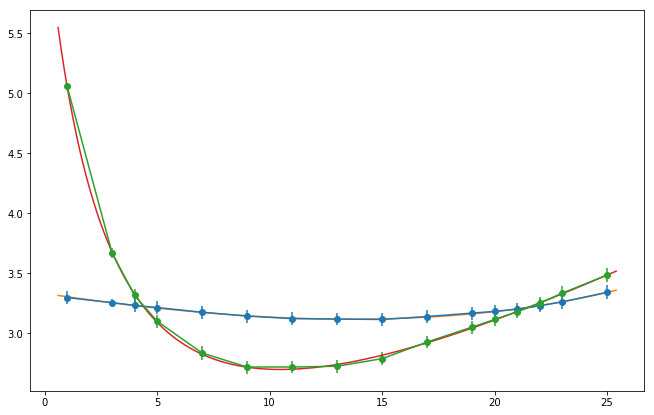

In [153]:
fit = fun3
sc = 1 # damit überprüfen wir ob die Numerik passt

p02 = [1, 0.1, -1, 1]
p01=array([sc*-219.66, sc*-0.10434951, 61, 2.66])

mess1 = [1, 1/sqrt(4)] + [1]*14
popt1, pcov1 = scipy.optimize.curve_fit(fit, n, sc*T1**2, p0=p01, sigma=2*T1**2*devq*mess1,
                                        jac=jac3)

# popt1, pcov1 = fit_curve(fit, n, sc*T1_**2, p0=[sc*-219.66, sc*-0.10434951, 61, 2.66],
#                          sigma=2*T1_**2*devq*mess1, jac=jac3,
#                          fixed=[None, None, None, None])
# 2.19664136e+02,  1.08189235e-01

popt1, sqrt(diag(pcov1))
cond(pcov1)
x = linspace(min(n) - .4, max(n) + .4, 1000)
_ = plt.errorbar(n, sc*T1**2, yerr=2*T1**2*devq*mess1, fmt='o-')
_ = plt.plot(x, vectorize(fit)(x, *popt1))


mess2 = [1/sqrt(4), 1/sqrt(2)] + [1]*14
popt2, pcov2 = scipy.optimize.curve_fit(fit, n, T2**2, p0=p02, sigma=2*T2**2*devq*mess2, jac=jac3)

popt2, sqrt(diag(pcov2))
cond(pcov2)
_ = plt.errorbar(n, T2**2, yerr=2*T1**2*devq*mess2, fmt='o-')
_ = plt.plot(x, vectorize(fit)(x, *popt2))

# plt.legend(['Fit 1', 'Fit 2', '${T_2}^2$', '${T_1}^2$'])

In [24]:
([-1e2]*5, [1e2]*5)

([-100.0, -100.0, -100.0, -100.0, -100.0], [100.0, 100.0, 100.0, 100.0, 100.0])

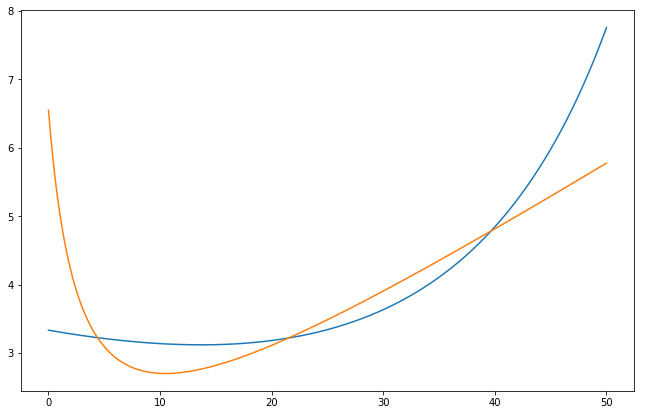

In [31]:
x = linspace(0, 50, 1000)
_ = plt.plot(x, vectorize(fit)(x, *popt1))
_ = plt.plot(x, vectorize(fit)(x, *popt2))
# plt.ylim(-20, 20)

In [55]:
z1 = scipy.optimize.newton(lambda x: fun3(x, *popt1) - fun3(x, *popt2), 4.4, fprime=lambda x: dx(x, *popt1) - dx(x, *popt2))
z2 = scipy.optimize.newton(lambda x: fun3(x, *popt1) - fun3(x, *popt2), 21.5, fprime=lambda x: dx(x, *popt1) - dx(x, *popt2))
print(z1, z2)

4.395324051472461 21.51323480689299


In [164]:
tau1 = fun3(z1, *popt1)
tau2 = fun3(z2, *popt1)
print(tau1, tau2, tau1 - tau2)

3.222750977105531 3.2176265421188424 0.005124434986688797


In [111]:
def grad1y(x, popt1, popt2):
    return -jac3(x, *popt1) * dx(x, *popt2) / (dx(x, *popt1) - dx(x, *popt2))

def grad2y(x, popt1, popt2):
    return -jac3(x, *popt2) * dx(x, *popt1) / (dx(x, *popt2) - dx(x, *popt1))

In [158]:
grad1y(z1, popt1, popt2)
grad2y(z1, popt1, popt2)

grad1y(z2, popt1, popt2)
grad2y(z2, popt1, popt2)

array([ -0.01567154, -11.8945147 ,  -0.05050546,   0.02312134])

array([-0.01289119, -0.60453694, -0.0415451 , -0.02312134])

array([-0.03029634, -3.29694287, -0.0974823 , -0.04358617])

array([ -0.02443118, -14.03243045,  -0.0786104 ,   0.04358617])

In [97]:
p1 = popt1
p2 = popt2 + [0, 0, 0, 0]
fun3(scipy.optimize.newton(lambda x: fun3(x, *p1) - fun3(x, *p2), 4.395, fprime=lambda x: dx(x, *p1) - dx(x, *p2)), *p1)

3.222750977105531

In [183]:
var_z1 = grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z1, popt1, popt2) + \
         grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z1, popt1, popt2)

# grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z1, popt1, popt2)
# grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z1, popt1, popt2)

var_z2 = grad1y(z2, popt1, popt2) @ pcov1 @ grad1y(z2, popt1, popt2) + \
         grad2y(z2, popt1, popt2) @ pcov2 @ grad2y(z2, popt1, popt2)

print(sqrt(var_z1), sqrt(var_z2))
cov_z = grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z2, popt1, popt2) + \
        grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z2, popt1, popt2)
print()
COV = array([[var_z1, cov_z], [cov_z, var_z2]])
print(COV)
assert all(eigvals(COV) > 0) # Kovarianzmatrix sollte positiv definit sein

0.0017627450336136533 0.004443283088548802

[[ 3.10727005e-06 -1.01491197e-06]
 [-1.01491197e-06  1.97427646e-05]]


In [194]:
A = inv(COV)
w1 = (A[0, 0] + A[0, 1]) / (sum(A, (0, 1)))
w2 = (A[1, 0] + A[1, 1]) / (sum(A, (0, 1)))
print(w1, w2)
tau = w1*tau1 + w2*tau2
var_tau = [w1, w2] @ COV @ [w1, w2]
err_tau = sqrt(var_tau)
print(f'{tau} +- {err_tau}')

0.8343165011453129 0.1656834988546871
3.2219019427872833 +- 0.001557013973262607


In [207]:
l = 0.800
err_l = 0.0005

4 * pi**2 * 0.80 / tau
e1 = 4 * pi**2 * 0.8 / tau**2 * err_tau
e2 = 4 * pi**2 / tau * err_l
sqrt(e1**2 + e2**2)

9.802512504823026

0.007744385156885916

In [205]:
err_tau / tau

0.0004832592676348264